We are now going to learn about mixture models; models that combine pieces of several different distributions in intereting ways. These types of models can help with over-dispersion, zero-inflation, and ordered categories.

In [1]:
import sys, re, warnings

import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.special import factorial
import matplotlib.pyplot as plt
import torch
tt =  torch.tensor
from torch.distributions import TransformedDistribution
import pyro
from pyro.distributions import (
    Beta,
    BetaBinomial,
    Binomial,
    Categorical,
    Delta,
    Dirichlet,
    Exponential,
    Gamma,
    GammaPoisson,
    Normal,
    Poisson,
    TorchDistribution,
    TransformedDistribution,
    ZeroInflatedPoisson,
)
from pyro.distributions.transforms import Transform
from pyro.ops.stats import hpdi, waic, resample
from pyro.infer import Predictive
from pyro.distributions import constraints
import arviz as az 
from utils import train_nuts, unnest_samples, traceplot, precis, plot_intervals

torch.multiprocessing.set_sharing_strategy("file_system")

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Sep 03 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

sys       : 3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]
pyro      : 1.9.1
torch     : 2.3.0
re        : 2.2.1
matplotlib: 3.9.0
numpy     : 1.26.4
pandas    : 2.2.2
scipy     : 1.12.0
arviz     : 0.17.1

Watermark: 2.4.3



### Code 12.1 - 12.5
First we will deal with overdispersion, which is where data appears to have a wider variance than is allowed by the base distribution (for example, the Poisson and binomial don't have a lot of leeway to alter the variance while keeping the mean fixed). One example of a distribution that allows you to handle this is the beta-binomial.

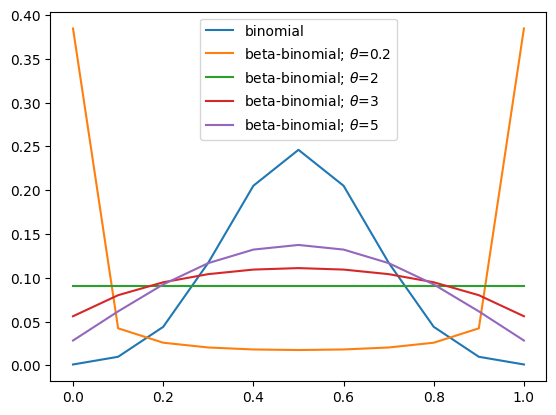

In [3]:
N = 10
p = 0.5
x = np.linspace(0, 1, N+1)
theta = 5
k = torch.arange(N+1).double()
y1 = Binomial(N, probs=p).log_prob(k).exp()
y2 = BetaBinomial(p*(theta-2)+1, (1-p)*(theta-2)+1, N).log_prob(k).exp()
theta = 2
y3 = BetaBinomial(p*(theta-2)+1, (1-p)*(theta-2)+1, N).log_prob(k).exp()
theta = 3
y4 = BetaBinomial(p*(theta-2)+1, (1-p)*(theta-2)+1, N).log_prob(k).exp()
theta = 0.2
y5 = BetaBinomial(p*(theta-2)+1, (1-p)*(theta-2)+1, N).log_prob(k).exp()
plt.plot(x, y1, label="binomial")
plt.plot(x, y5, label=r"beta-binomial; $\theta$=0.2")
plt.plot(x, y3, label=r"beta-binomial; $\theta$=2")
plt.plot(x, y4, label=r"beta-binomial; $\theta$=3")
plt.plot(x, y2, label=r"beta-binomial; $\theta$=5")
plt.legend()
plt.show()

It gets its name from the fact that it is the distribution you would get if you sampled the binomal parameter $p$ from a beta distribution. This adds a bit more uncertainty to samples from the resulting binomial, so it is broader than the binomial by itself. Let's take a look at the UC Berkely admittance dataset again, and use this distribution to help model the increased variance in admittance rates (without accounting for department):
$$
A_i \sim \text{Beta-Binomial}(N_i, \bar{p}_i, \theta_i) \\
\bar{p}_i = \exp(\alpha_\text{GID[i]}) \\
\alpha \sim \text{Normal}(0, 1.5) \\
\theta = \phi + 2\\
\phi \sim \text{Exponential}(1)
$$

In [4]:
ucb_df = pd.read_csv("data/UCBadmit.csv", sep=";")
ucb_df.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [5]:
data = {
    "applications": tt(ucb_df["applications"].values).double(),
    "gender_id": tt(ucb_df["applicant.gender"].map({"male": 0, "female": 1}).values).long(),
    "admit": tt(ucb_df["admit"].values).double()
}

In [6]:
def model_m12_1(data, training=False):
    phi = pyro.sample("ϕ", Exponential(1.0))
    theta = pyro.deterministic("θ", phi+2)
    alpha = pyro.sample("α", Normal(0., 1.5)\
                        .expand([2])\
                        .to_event(1))
    pbar = torch.sigmoid(alpha)
    c1, c0 = pbar*theta, (1-pbar)*theta
    c1, c0 = c1[data["gender_id"]], c0[data["gender_id"]]
    if training:
        pyro.sample("obs", BetaBinomial(c1, c0, data["applications"]), obs=data["admit"])
    else:
        return pyro.sample("obs", BetaBinomial(c1, c0, data["applications"]))

In [7]:
# https://github.com/pyro-ppl/numpyro/blob/master/examples/baseball.py
def model_m12_1(data, training=False):
    phi = pyro.sample("ϕ", Exponential(1.0))
    theta = pyro.deterministic("θ", phi+2)
    alpha = pyro.sample("α", Normal(0., 1.5).expand([2]).to_event(1))
    pbar = torch.sigmoid(alpha)
    if training:
        with pyro.plate("N", len(data["admit"]), dim=-1) as i:
            gid = data["gender_id"][i]
            phi_prior = Beta(pbar[gid] * theta, (1 - pbar[gid]) * theta)
            phi = pyro.sample("phi", phi_prior)
            pyro.sample("obs", Binomial(data["applications"][i], phi), obs=data["admit"][i])
    else:
        with pyro.plate("N") as i:
            gid = data["gender_id"][i]
            phi_prior = Beta(pbar[gid] * theta, (1 - pbar[gid]) * theta)
            phi = pyro.sample("phi", phi_prior)
            return pyro.sample("obs", Binomial(data["applications"][i], phi))

In [8]:
m12_1 = train_nuts(model_m12_1, data, 5000, 5000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Warmup:   0%|          | 0/10000 [00:00, ?it/s]/tmp/ipykernel_4856/2715638131.py:8: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  with pyro.plate("N", len(data["admit"]), dim=-1) as i:
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/pyro/poutine/subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 10000/10000 [00:49, 202.26it/s, step size=3.98e-01, acc. prob=0.943]


In [9]:
m12_1.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    phi[0]      0.62      0.02      0.62      0.59      0.65   6381.37      1.00
    phi[1]      0.81      0.04      0.82      0.76      0.88   5716.16      1.00
    phi[2]      0.63      0.02      0.63      0.60      0.66   6182.21      1.00
    phi[3]      0.65      0.09      0.66      0.50      0.80   6146.26      1.00
    phi[4]      0.37      0.03      0.37      0.33      0.41   6322.96      1.00
    phi[5]      0.34      0.02      0.34      0.31      0.37   6967.97      1.00
    phi[6]      0.33      0.02      0.33      0.29      0.37   5627.31      1.00
    phi[7]      0.35      0.02      0.35      0.31      0.39   5727.38      1.00
    phi[8]      0.28      0.03      0.28      0.22      0.33   6303.08      1.00
    phi[9]      0.24      0.02      0.24      0.20      0.27   5998.69      1.00
   phi[10]      0.06      0.01      0.06      0.04      0.08   6042.42      1.00
   phi[11]      0.07      0

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'ϕ'}>, <Axes: title={'center': 'ϕ'}>]],
      dtype=object)

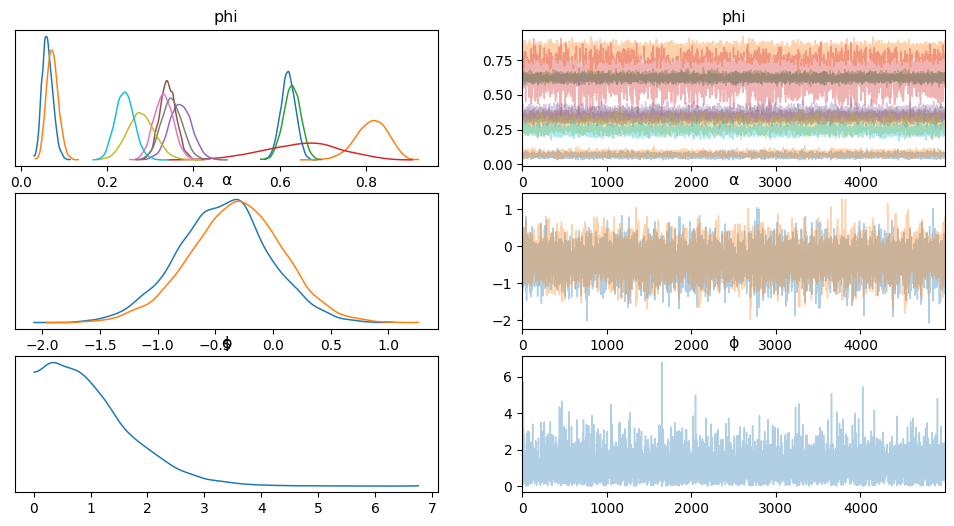

In [10]:
az.plot_trace(az.from_pyro(m12_1))

In [11]:
samples = unnest_samples(m12_1.get_samples())
s = {k: v.numpy() for k, v in samples.items()}

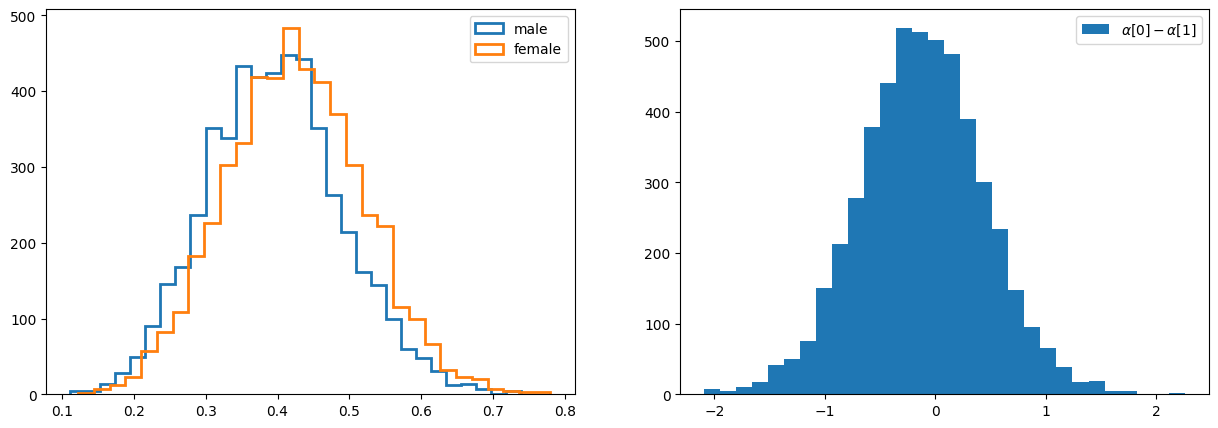

In [12]:
s = unnest_samples(m12_1.get_samples())
s["θ"] = s["ϕ"] + 2
s["da"] = s["α[0]"] - s["α[1]"]
s = {k: v.numpy() for k, v in s.items()}
p_male = torch.sigmoid(samples["α[0]"])
p_female = torch.sigmoid(samples["α[1]"])
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plt.sca(axes[0])
plt.hist(p_male, bins=30, histtype="step", linewidth=2, label="male")
plt.hist(p_female, bins=30, histtype="step", linewidth=2, label="female")
plt.legend()
plt.sca(axes[1])
plt.hist(s["da"], bins=30, label=r"$\alpha[0] - \alpha[1]$")
plt.legend()
plt.show()

In [13]:
precis(s)

,mean,stddev,5.5%,94.5%
ϕ,1.025362,0.767138,0.106708,2.416432
phi[0],0.619803,0.017081,0.592272,0.647208
phi[1],0.813462,0.037118,0.750514,0.86957
phi[2],0.62879,0.020086,0.595786,0.660244
phi[3],0.650019,0.089789,0.498625,0.787889
phi[4],0.369946,0.026434,0.328119,0.412405
phi[5],0.340966,0.019595,0.310748,0.372331
phi[6],0.330892,0.02269,0.295801,0.367037
phi[7],0.349593,0.024853,0.310711,0.389397
phi[8],0.278655,0.032422,0.227762,0.331087


This model is extremely uncertain about the difference between the genders; but if you recall back to the first time we looked at this data, that model (using a regular binomial distribution) was confounded without using the department as a predictor, and predicted that males had significantly higher admission rates than females. In this case, the model is not confounded because the variation in prior probabilities for $\bar{p}$ can account for the variation in admission rates between departments!

Let's examine the distribution of beta distributions underlying our beta-binomial!

In [14]:
def inv_logit(x):
    return torch.exp(x)/(1+torch.exp(x))

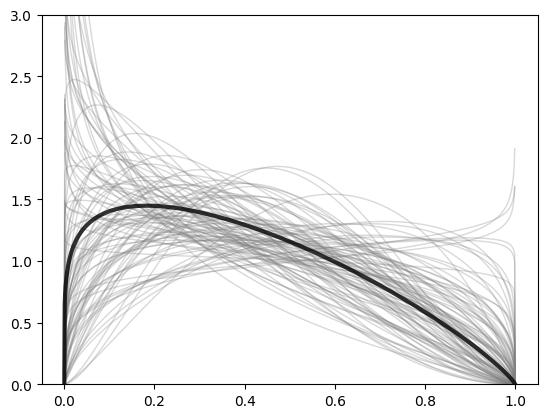

In [15]:
N = 100
idx = np.random.choice(len(s["θ"]), N, replace=False)
theta = s["θ"]
theta_mean = theta.mean()
pbar = torch.sigmoid(samples["α[0]"])
c1, c0 = pbar*theta, (1-pbar)*theta
x = np.linspace(0, 1, 1000)
for i in idx:
    y = Beta(c1[i], c0[i]).log_prob(tt(x)).exp().numpy()
    plt.plot(x, y, color="gray", alpha=0.3, linewidth=1)

pbar_mean = torch.sigmoid(samples["α[0]"].mean())
y =  Beta(pbar_mean*theta_mean, (1-pbar_mean)*theta_mean).log_prob(tt(x)).exp().numpy()
plt.plot(x, y, color="black", alpha=0.8, linewidth=3)
plt.ylim(0,3)
plt.show()

And we should also do a posterior validation check:

In [16]:
s = m12_1.get_samples()
p = inv_logit(s["α"][:,data["gender_id"]])
pbar = p.mean(dim=0)
pbar_q = hpdi(p, 0.89, dim=0)
print(p.shape, pbar.shape, pbar_q.shape)

torch.Size([5000, 12]) torch.Size([12]) torch.Size([2, 12])


torch.Size([5000, 12]) torch.Size([5000, 12])


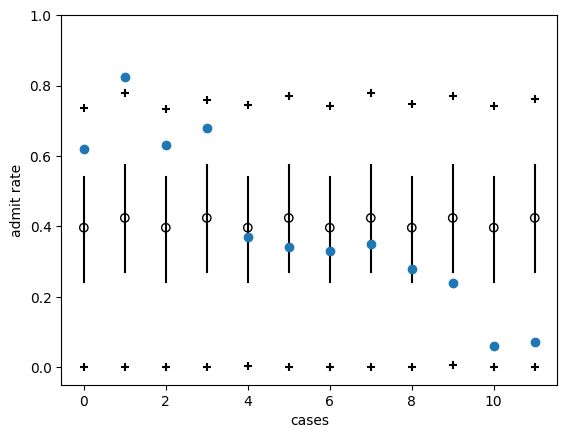

In [17]:
c1, c0 = pbar[None, :]*theta[:,None], (1-pbar[None, :])*theta[:,None]
print(c1.shape, c0.shape)
for i in range(len(data["applications"])):
    n = data["applications"][i]
    admit_rate_obs = data["admit"][i]/n
    admit_rate = BetaBinomial(c1[:, i], c0[:, i], n).sample()/n
    q = hpdi(admit_rate, prob=0.89)
    #print(i, q.numpy().round(2), pbar_q[:,i].numpy().round(2), pbar[i].numpy().round(2), pbar[i].numpy().round(2))
    # + symbols mark the 89% interval of predicted counts of admission
    plt.scatter([i, i], q, marker="+", color="black")
    # The open circles are the posterior mean p̄
    plt.scatter(i, pbar[i], facecolor="none", edgecolor="black")
    # with 89% percentile interval
    plt.plot([i, i], pbar_q[:, i], color="black")
    # The blue points show the empirical proportion admitted on each row of the data.
    plt.scatter(i, admit_rate_obs, color="C0", zorder=1000)
plt.xlabel("cases")
plt.ylabel("admit rate")
plt.ylim(-0.05,1)
plt.show()

The beta-binomial distribution obviously captures a lot more of the variation between departments than the binomial by itself.

### Code 12.7 - 12.11
Now we'll go over a class of mixture models known as zero-inflated models. Zero-inflated processes can arise when there are multiple ways to get a zero result from a process. For example, if we are modeling the number of manuscripts completed by monks at a monastery on any given day, on every day the monks work, they generate some number of manuscripts that is Poisson-distributed. However, on some days the monks go down into the cellar and drink, and no manuscripts are completed on that day. If they had been working, perhaps by chance no manuscripts may have been completed, but on the days they drink, they are guaranteed to not produce anything.

If the probability that the monks take a break and drink is $p$, and the probability that $k$ manuscripts are produced if they don't is given by a Poisson distribution, then the probability of getting zero (through either process) is
$$\begin{align}
\text{Pr}(0|p,\lambda) &= \text{Pr}(\text{drink}|p) + \text{Pr}(\text{work}|p) \times \text{Pr}(0|\lambda) \\
&= p + (1-p) \exp(-\lambda)
\end{align}$$
and the probability of getting $k>0$ is
$$\begin{align}
\text{Pr}(k|p,\lambda) &= \text{Pr}(\text{work}|p) \times \text{Pr}(k|\lambda) \\
&= (1-p) \frac{e^{-\lambda} \lambda^k}{k!}
\end{align}$$

Let's simulate some data and then try to recover the parameters used.

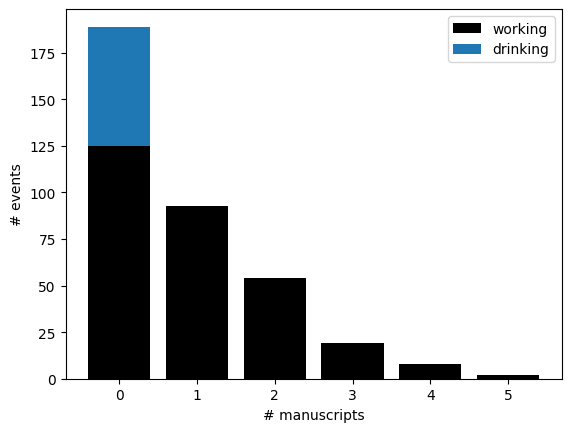

In [18]:
# define parameters
prob_drink = 0.2
rate_work  = 1.0
# sample one year
N = 365
# simulate days monks drink
drink = Binomial(1, prob_drink).sample([N])
# simulate productive days
manuscripts = (1 - drink)*(Poisson(rate_work).sample([N]))                                              
# make histogram
x, y = np.unique(manuscripts, return_counts=True)
plt.bar(x, y, color="black", label="working")
zeros_drink = drink.sum()
zeros_work = ((manuscripts == 0) & (drink == 0)).sum()
plt.bar([0], [zeros_drink], bottom=zeros_work, color="C0", label="drinking")
plt.ylabel("# events")
plt.xlabel("# manuscripts")
plt.legend()
plt.show()

In [19]:
data = {"manuscripts": manuscripts}

def model_m12_4(data, training=False):
    ap = pyro.sample("ap", Normal(-1.5, 1.0))
    al = pyro.sample("al", Normal(1., 0.5))
    lambda_ = torch.exp(al)
    p = torch.sigmoid(ap)
    if training:
        pyro.sample("M", ZeroInflatedPoisson(rate=lambda_, gate=p), obs=data["manuscripts"])
    else:
        return pyro.sample("M", ZeroInflatedPoisson(p, lambda_))
    


In [20]:
m12_4 = train_nuts(model_m12_4, data, 4000, 10000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 14000/14000 [00:20, 674.00it/s, step size=6.75e-01, acc. prob=0.891]


In [21]:
m12_4.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        al      0.17      0.08      0.17      0.04      0.31   3895.27      1.00
        ap     -0.87      0.24     -0.85     -1.25     -0.48   3805.44      1.00

Number of divergences: 0


p 	 =  0.298
lambda 	 =  1.191


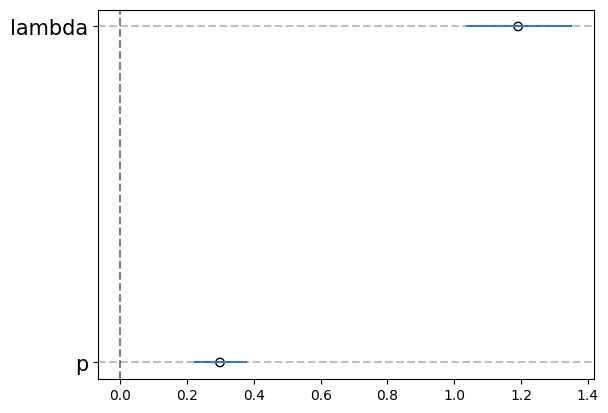

In [22]:
s = m12_4.get_samples()
s["p"] = torch.sigmoid(s["ap"])
s["lambda"] = torch.exp(s["al"])
del s["ap"], s["al"]
print("p \t = ",      round(s["p"].mean().item(), 3))
print("lambda \t = ", round(s["lambda"].mean().item(), 3))
plot_intervals(s, 0.89)
plt.show()

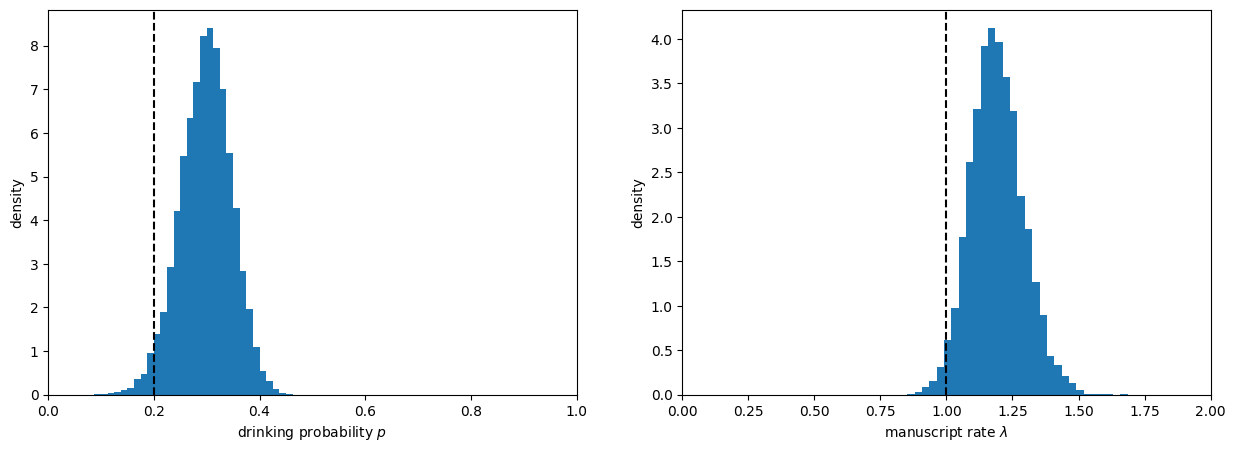

In [23]:
s = m12_4.get_samples()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plt.sca(axes[0])
plt.hist(torch.sigmoid(s["ap"]), bins=30, density=True)
plt.axvline(0.2, color="black", linestyle="--")
plt.xlabel(r"drinking probability $p$")
plt.ylabel("density")
plt.xlim(left=0, right=1)
plt.sca(axes[1])
plt.hist(torch.exp(s["al"]), bins=30, density=True)
plt.axvline(1, color="black", linestyle="--")
plt.xlabel(r"manuscript rate $\lambda$")
plt.ylabel("density")
plt.xlim(left=0, right=2)
plt.show()

Not bad; we recover the parameters fairly well (see above; true values are vertical dashed lines).